#Project 3: Semantic Segmentation with Fully Convolutional Networks 
Dataset: CityScapes urban scene image dataset 

References: 
https://pytorch.org/vision/main/_modules/torchvision/datasets/cityscapes.html

https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

https://www.youtube.com/watch?v=hWN1Xqu8aRE

https://github.com/wkentaro/pytorch-fcnhttps://github.com/shelhamer/fcn.berkeleyvision.org

**As always, thanks to Fei-Fei Lee, Justin Johnson and Andrej Karpathy from Stanford for their open source CS231n material 

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import standard packages 
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
from torch.utils.data import TensorDataset, DataLoader, Dataset
import albumentations.augmentations.functional as F
import torchvision 
from typing import Tuple, Any
from torchvision import datasets, models
import torchvision.transforms as T
import albumentations as A 
from albumentations.pytorch import ToTensorV2
import torchmetrics
from torchvision.datasets import Cityscapes
from PIL import Image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Load the dataset: 
#We  load the "finer" segmentations over the coarser ones to begin with
urbanSet = Cityscapes(root='/content/drive/MyDrive/CS231N/Projects_The_good_stuff/P3SS/data', 
                      split = "train", mode = 'fine', target_type= 'semantic')

In [ ]:
#Figuring out how data is sorted in the dataset 
print(urbanSet[0][0].size)
#findings- data is organized in the following manner:
#image # in the first [], type in the second 
#type can be RGB or L, where L is the semantically labeled image (output)
for img, label in urbanSet:
  print(img)
  print(label)
  break

(2048, 1024)
<PIL.Image.Image image mode=RGB size=2048x1024 at 0x7FA38B784950>
<PIL.PngImagePlugin.PngImageFile image mode=L size=2048x1024 at 0x7FA382060B50>


**Visualizing the data**

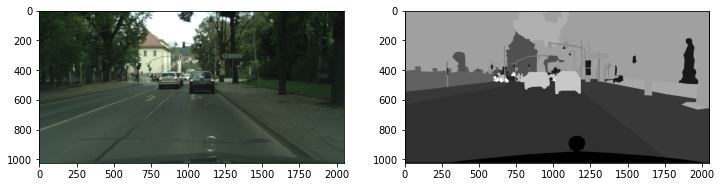

In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(12,8))
axs[0].imshow(urbanSet[1][0])
axs[1].imshow(urbanSet[1][1], cmap='gray')

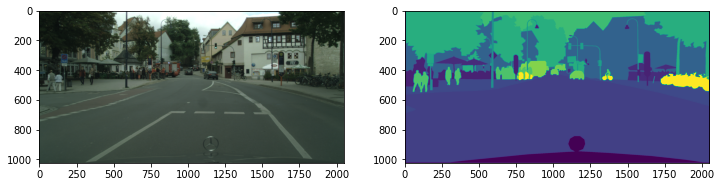

In [ ]:
fig2, axs2 = plt.subplots(ncols=2,figsize=(12,8))
axs2[0].imshow(urbanSet[2][0])
axs2[1].imshow(urbanSet[2][1])

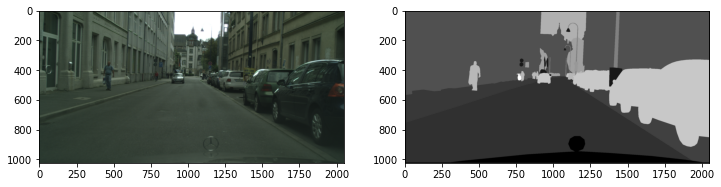

In [ ]:
fig3, axs3 = plt.subplots(ncols=2,figsize=(12,8))
axs3[0].imshow(urbanSet[10][0])
axs3[1].imshow(urbanSet[10][1], cmap='gray')

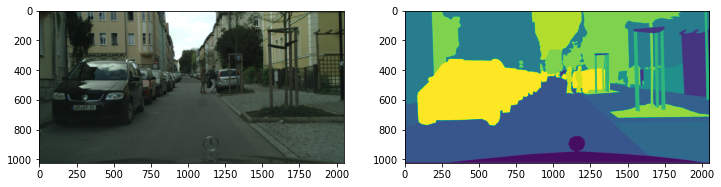

In [ ]:
fig4, axs4 = plt.subplots(ncols=2,figsize=(12,8))
axs4[0].imshow(urbanSet[50][0])
axs4[1].imshow(urbanSet[50][1])

**Understanding the labels**

https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py gives us a detailed understanding of the different classes as well as class types 
"Note that you might want to ignore labels with ID 255 during training." - from the source... this is because those within this trainId are not dominant object types 

In [ ]:
trainId_ignored = 255 
ids_ignored = [0,1,2,3,4,5,6,9,10,14,15,16,18,29,30,-1]
ids_kept = [255, 7,8,11,12,13,17,19,20,21,22,23,24,25,26,27,28,31,32,33]
class_names = ['unlabeled','road','sidewalk','building' , 'wall', 'fence', 'pole',
               'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 
               'person',  'rider','car', 'truck', 'bus', 'train', 'motorcycle',
               'bicycle']
map_classes = dict(zip(ids_kept, range(len(ids_kept))))
num_classes = len(ids_kept)
print(map_classes)

{255: 0, 7: 1, 8: 2, 11: 3, 12: 4, 13: 5, 17: 6, 19: 7, 20: 8, 21: 9, 22: 10, 23: 11, 24: 12, 25: 13, 26: 14, 27: 15, 28: 16, 31: 17, 32: 18, 33: 19}


In [ ]:
colors_kept = [[0,0,0],[128, 64,128], [244, 35,232], 
               [ 70, 70, 70], [102,102,156], [190,153,153], [153,153,153], 
               [250,170, 30], [220,220,  0], [107,142, 35], [152,251,152],
               [70,130,180], [220, 20, 60], [255,  0,  0], [ 0,  0,142], 
               [0,  0, 70], [0, 60,100], [0, 80,100], [ 0,  0,230], 
               [119, 11, 32]]

map_colors_labels = dict(zip(range(len(ids_kept)), colors_kept))
print(map_colors_labels)

{0: [0, 0, 0], 1: [128, 64, 128], 2: [244, 35, 232], 3: [70, 70, 70], 4: [102, 102, 156], 5: [190, 153, 153], 6: [153, 153, 153], 7: [250, 170, 30], 8: [220, 220, 0], 9: [107, 142, 35], 10: [152, 251, 152], 11: [70, 130, 180], 12: [220, 20, 60], 13: [255, 0, 0], 14: [0, 0, 142], 15: [0, 0, 70], 16: [0, 60, 100], 17: [0, 80, 100], 18: [0, 0, 230], 19: [119, 11, 32]}


In [ ]:
t_transform = A.Compose([A.Resize(256,512),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                      ToTensorV2(),])

In [ ]:
#abstracting cityscapes class to make transforms albumentations compatible 
#this way, I can transform both image and segmask in parallel 
class CustomDataset(Cityscapes):
  def __getitem__(self, index: int)  -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is a tuple of all target types if target_type is a list with more
            than one item. Otherwise target is a json object if target_type="polygon", else the image segmentation.
        """

        image = Image.open(self.images[index]).convert("RGB")

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == "polygon":
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])

            targets.append(target)

        target = tuple(targets) if len(targets) > 1 else targets[0]


        if self.transforms is not None:
            transformed = t_transform(image = np.array(image), mask = np.array(target))

        return transformed['image'], transformed['mask']

In [ ]:
#The following function allows re-configuring the data to reflect the new id schema 
def reclassify(mask, ignored, id_ignored, kept, class_map):
  for id in ignored:
    mask[mask==id] = id_ignored
  for id in kept:
    mask[mask==id] = class_map[id]
  return mask

In [ ]:
#function inspired by https://github.com/jfzhang95/pytorch-deeplab-xception/blob/master/dataloaders/utils.py
def decode_segmentation(tmp, colors, n_classes):
  #colorizes the segmentation map 
  #based on the color scheme defined by the problem 
  tmp = tmp.numpy()
  r = tmp.copy()
  g = tmp.copy()
  b = tmp.copy()
  
  for ll in range(0, n_classes):
    r[ll==tmp] = colors[ll][0]
    g[ll==tmp] = colors[ll][1]
    b[ll==tmp] = colors[ll][2]

  rgb = np.zeros((tmp.shape[0], tmp.shape[1], 3))
  rgb[:,:,0] = r / 255.0
  rgb[:,:,1] = g / 255.0
  rgb[:,:,2] = b / 255.0
 
  return rgb


In [ ]:
train_set = CustomDataset(root='/content/drive/MyDrive/CS231N/Projects_The_good_stuff/P3SS/data',
                          split = "train", mode = 'fine', target_type= 'semantic', 
                          transforms=t_transform)

In [ ]:
img, segmap = train_set[30]
print(train_set[30][1])
reclassified_segmap = reclassify(torch.squeeze(segmap.clone()), ids_ignored,255,ids_kept,map_classes)
colored_segmap = decode_segmentation(reclassified_segmap.clone(), colors_kept, 20)

tensor([[ 3,  3,  3,  ...,  3,  3,  3],
        [ 3,  3,  3,  ...,  3,  3,  3],
        [ 3,  3, 21,  ..., 21, 21,  3],
        ...,
        [ 3,  3,  7,  ...,  8,  8,  3],
        [ 3,  3,  7,  ...,  8,  8,  3],
        [ 3,  3,  3,  ...,  3,  3,  3]], dtype=torch.uint8)


In [ ]:
print(segmap[0])
print("-"*15)
print(reclassified_segmap[0])
print("-"*15)
print(reclassified_segmap.size())

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

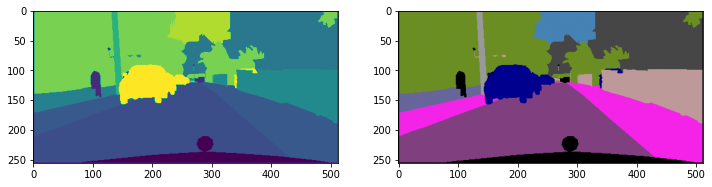

In [ ]:
fig5, axs5 = plt.subplots(ncols=2,figsize=(12,8))
axs5[0].imshow(segmap)
axs5[1].imshow(colored_segmap)

**Network Architecture:**

Ideally: FCN 8 - best model proposed in initial FCN for semantic segmentation paper. Uses pretrained ConvNet on ImageNet, swaps fully connected layers for convolutional layers and unsampling layers 

Attempt 1 architecture: Swap all FCs with convolutional layers (need to figure out kernel size) 
"Decapitate last classification layer" -> swap last classification layer with backwards strided convolution; This is FCN-32, the most basic FCN for semantic segmentation (without the skip architecture) Once I have this working, I can move to FCN-16 to start to addd in a skip architecture, and then advance to an FCN-8 

In [ ]:
#VGG16 produced the best results in the original paper 
#We want to load a pretrained VGG net, swap the FCs for conv layers, and add 

In [ ]:
def parameter_gradients(model, detach):
  if detach:
    for param in model.parameters():
      param.requires_grad = False

In [ ]:
class funSegNet(nn.Module):
  #As of now, even though we're taking ImageNet model name as a parameter, the
  #filter swapping is very much hardcoded for vgg16, so even though this may seem
  #modular, it isn't (yet)  
  
  def __init__(self, net_name):
    super(funSegNet, self).__init__()
    ImageNetPreTrain = getattr(models, net_name)
    self.model = ImageNetPreTrain(pretrained = True)
    parameter_gradients(self.model, True)
    self.model.features[0].padding = (100, 100)
    #Get rid of the average pooling layer by swapping it with identity 
    self.model.avgpool = nn.Identity()
    self.model.classifier[0] = nn.Conv2d(in_channels=512, out_channels=4096, 
                                         kernel_size=7)
    self.model.classifier[3] = nn.Conv2d(in_channels = 4096, out_channels=4096, 
                                         kernel_size=1)
    self.model.classifier[6] = nn.Conv2d(in_channels= 4096, out_channels= 20,
                                         kernel_size=1)
    #At this point, we have swapped all FCs for conv layers. We now must 
    #upsample, crop and compute output 
    self.upscore = nn.Sequential(nn.ConvTranspose2d(in_channels=20, out_channels=20, 
                                                    kernel_size=64, stride = 32))
    print(self)

  
  def forward(self, x): 
    x_size = x.size()
    out = self.model.features(x)
    out = self.model.avgpool(out)
    out = self.model.classifier(out)
    out = self.upscore(out)
    return out[:, :, 19: (19 + x_size[2]), 19: (19 + x_size[3])].contiguous()

In [ ]:
model = funSegNet("vgg16")
model = model.to(device)
print(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


funSegNet(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

Training plan: 
1. Write a data processing function that's able to leverage reclassify and decode_segmentation to process training data for the purpose of this project 
2. Write a train function (understand how to relay inputs through to the output stage) 
3. Understand how to compute loss 
4. Print Semantic output (see what it looks like, figure out if something looks insanely wrong) 
5. Fix issues that come up in the first 4 steps 
6. Start playing with optimizers/loss functions
7. Start playing with hyperparameters 


In [ ]:
def process_data(img, seg): 
  segmap_out = reclassify(seg)
  return segmap_out

In [ ]:
#Function Definition for training 
#Inputs: model, data loaders for train + validation, loss function, optimizer, # epochs 
#GPU/CPU 
#outputs: none 
#Does: Trains model against new dataset, updates weights and prints training/validation 
#loss and accuracy 
def train(model, data_loaders, criterion, optimizer, epochs, device):
  loss_plot = []
  trainId_ignored = 255 
  ids_ignored = [0,1,2,3,4,5,6,9,10,14,15,16,18,29,30,-1]
  ids_kept = [255, 7,8,11,12,13,17,19,20,21,22,23,24,25,26,27,28,31,32,33]
  class_names = ['unlabeled','road','sidewalk','building' , 'wall', 'fence', 'pole',
               'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 
               'person',  'rider','car', 'truck', 'bus', 'train', 'motorcycle',
               'bicycle']
  map_classes = dict(zip(ids_kept, range(len(ids_kept))))
  num_classes = len(ids_kept)
  #metrics = torchmetrics.iou
  for epoch in range(epochs):
    
    #State current epoch 
    print("Epoch %d / %d" % (epoch, epochs-1))
    print("-"*10)

    #either train or evaluate based on dataset 
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else: 
        model.eval()

      running_loss = 0.0 
      correct = 0 
      
      #Load data in batches 
      for x_batch, y_batch in data_loaders[phase]: 
        x_var = x_batch.to(device)
        y_var = y_batch.to(device)
        y_var = reclassify(y_var, ids_ignored,trainId_ignored,
                                         ids_kept,map_classes)

        with torch.set_grad_enabled(phase=='train'):
          outputs = model(x_var)
          loss = criterion(outputs, y_var.long())
 
          _, preds = torch.max(outputs,1)
          optimizer.zero_grad()
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        loss_plot.append(loss.item())
        running_loss +=loss.item() * x_var.size(0)
        correct += torch.sum(preds == y_var.data)
        
    
    epochLoss = running_loss / len(data_loaders[phase].dataset)
    epochAcc = 100 * (correct.double() / len(data_loaders[phase].dataset))

    print('Phase: {}, current Epoch loss: {:.4f}, accuracy: {:.2f} %'.format(phase, epochLoss, epochAcc))
  
  plt.plot(range(len(loss_plot)), loss_plot, '-')
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()

In [ ]:
validation_set = CustomDataset(root='/content/drive/MyDrive/CS231N/Projects_The_good_stuff/P3SS/data', 
                      split = "val", mode = 'fine', transform = t_transform,target_type= 'semantic')

In [ ]:
print(validation_set)

Dataset CustomDataset
    Number of datapoints: 500
    Root location: /content/drive/MyDrive/CS231N/Projects_The_good_stuff/P3SS/data
    Split: val
    Mode: gtFine
    Type: ['semantic']
    StandardTransform
Transform: Compose([
             Resize(always_apply=False, p=1, height=256, width=512, interpolation=1),
             Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
             ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
           ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [ ]:
batch_size = 8
train_loader = DataLoader(dataset = train_set, 
                          batch_size=batch_size, 
                          shuffle = True)
val_loader = DataLoader(dataset = validation_set, 
                          batch_size=batch_size, 
                          shuffle = True)

In [ ]:
data_loaders = {}
data_loaders['train'] = train_loader
data_loaders['val'] = val_loader

In [ ]:
#Hyperparams 
alpha = 1e-3
beta = 0.9
epochs = 10 

Epoch 0 / 9
----------
Phase: val, current Epoch loss: 2.5840, accuracy: 4314636.40 %
Epoch 1 / 9
----------
Phase: val, current Epoch loss: 2.3485, accuracy: 4314636.40 %
Epoch 2 / 9
----------
Phase: val, current Epoch loss: 2.2293, accuracy: 4314636.40 %
Epoch 3 / 9
----------
Phase: val, current Epoch loss: 2.1627, accuracy: 4314636.40 %
Epoch 4 / 9
----------
Phase: val, current Epoch loss: 2.1207, accuracy: 4314636.40 %
Epoch 5 / 9
----------
Phase: val, current Epoch loss: 2.0919, accuracy: 4314636.40 %
Epoch 6 / 9
----------
Phase: val, current Epoch loss: 2.0709, accuracy: 4314636.40 %
Epoch 7 / 9
----------
Phase: val, current Epoch loss: 2.0544, accuracy: 4314636.40 %
Epoch 8 / 9
----------
Phase: val, current Epoch loss: 2.0392, accuracy: 4314636.40 %
Epoch 9 / 9
----------
Phase: val, current Epoch loss: 2.0144, accuracy: 4314636.40 %


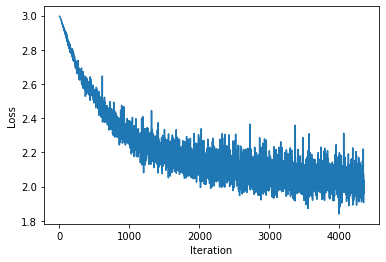

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = alpha, momentum = beta)
#current bug notes: the forward pass of VGG16 flattens the output of the conv
#nets for the FCs that were there... now that we're swapping these FCs for 
#fully convolutional layers, this is no longer required. Need to figure out 
#how to unsqueeze data in there 
train(model, data_loaders, criterion, optimizer, epochs, device)